## 対応のある2標本のt検定の事例

同じ母集団から無作為抽出された2つの標本にてついて、標本平均が等しいかどうか？を検定する。

### (0)事前準備

In [1]:
# ライブラリ
import os
import sys
sys.path.append("../../scripts")
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
np.random.seed(111)
import random
random.seed(111)

# scipy
from scipy import stats
# graph
import matplotlib.pyplot as plt
import seaborn as sns

# scripts
import utils as u
# graph setting
u.graph_setting()

### (0) テーマのためのデータセット

In [3]:
# scikit-learnに用意されている、アヤメのデータセットを使う
from sklearn.datasets import load_iris
iris = load_iris()

# irisのデータセットは、辞書型で格納されているので、扱いやすいようにpandasのデータフレームに変換する。
# 各特徴データ
df = pd.DataFrame(iris.data, columns=iris.feature_names)
# ラベル, 種類のデータ。各数値ラベルを名前に置き換えて加える。
df["target"] = [iris.target_names[t] for t in iris.target]

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [9]:
# データセットの準備
# 'setosa'のデータをランダマイズ
df_setosa = df[df["target"]=="setosa"].sample(frac=1).reset_index(drop=True)

# sampling values
values = df_setosa["sepal length (cm)"].values

# dataset 1, and 2 sample
values1 = values[:int(len(values)/2)]
values2 = values[int(len(values)/2):]

print(f"Sample count -> Sample1 : Sample2 = {len(values1)} / {len(values2)}")
values1, values2

Sample count -> Sample1 : Sample2 = 25 / 25


(array([5. , 5. , 5.1, 5.1, 4.9, 4.7, 5.4, 5.7, 4.6, 5.5, 4.9, 5.1, 4.8,
        5. , 4.8, 5.4, 4.4, 5.8, 4.4, 5. , 4.7, 5.1, 4.8, 5.1, 5.4]),
 array([4.6, 5. , 4.6, 5.1, 4.3, 4.4, 5. , 5.1, 5.5, 5.2, 4.6, 5.1, 5.4,
        5. , 5. , 5.7, 5.3, 4.5, 4.8, 4.9, 4.9, 5.2, 4.8, 5.2, 5.4]))

### (0) データを確認

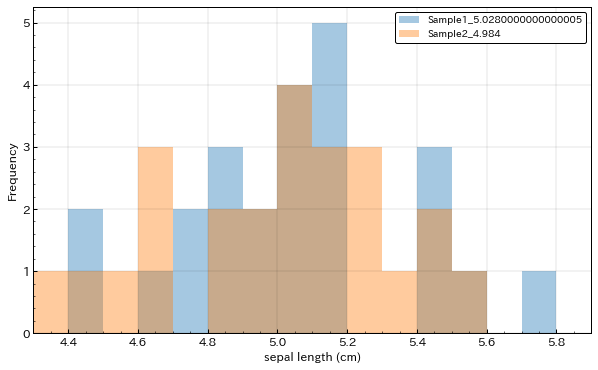

In [15]:
# ヒストグラム
fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(values1, bins=np.arange(np.min(values1)-0.1, np.max(values1)+0.1, 0.1), kde=False, ax=ax, label=f"Sample1_{np.mean(values1)}")
sns.distplot(values2, bins=np.arange(np.min(values2)-0.1, np.max(values2)+0.1, 0.1), kde=False, ax=ax, label=f"Sample2_{np.mean(values2)}")
ax.set_xlabel("sepal length (cm)")
ax.set_ylabel('Frequency')
ax.set_xlim([np.min(values1)-0.1, np.max(values1)+0.1])
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


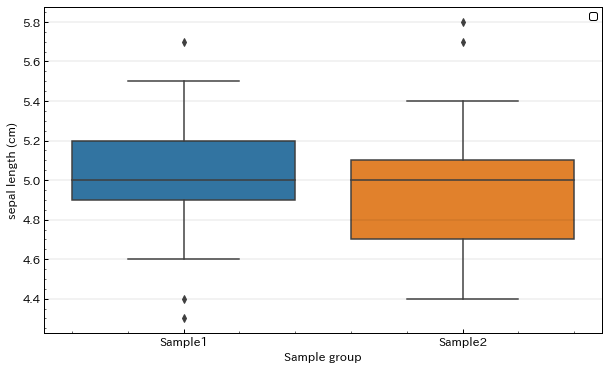

In [6]:
# ボックスプロット
fig, ax = plt.subplots(figsize=(10,6))

data = pd.concat([
       pd.DataFrame({"Sample":["Sample1" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"Sample":["Sample2" for i in range(len(values2))],
                     "Values":values2})
       ]).reset_index(drop=True)

sns.boxplot(data=data, x="Sample", y="Values")
ax.set_xlabel("Sample group")
ax.set_ylabel("sepal length (cm)")
ax.legend()

### (0) 想定する分析シーン

- ある花畑での'setosa'の'sepal length(cm)'を計測する。<br>
- 取得したデータはある2区画のデータとし25本ずつ抽出したものとする。<br>
*データセットは元のirisデータをランダムに2分割したものを、2つの区画のデータと仮定して取り扱う。<br>

それぞれの区画の平均値に差があるといえるか？を統計的に検定する。<br>

### (1) 問題設定
- 帰無仮説$H_0$と対立仮説$H_1$を定義する。<br>

帰無仮説$H_0$：'setosa'の'sepal length'の平均値は変わらない。<br>
対立仮説$H_1$：2つの区画の平均値が異なる。<br>

### (2) 適切な検定方法を選択する。
- 検定の目的、データの確認結果、サンプル数から適切な検定方法を選択する。<br>

1. 検定の目的<br>
-> 母集団から無作為抽出された2つの標本グループについて、その標本平均が等しいかどうか？を検定する。

2. データの確認 (ただし本分析においては仮定を置いたものとする。)<br>
    2-1. 正規性の仮定<br>
        -> 母集団の差は正規分布に従っている。<br>
    2-2. 独立性の仮定<br>
        -> 母集団内の個体同士は互いに独立している。<br>

3. サンプル数の確認<br>
    サンプル数：$n_1$=25, $n_2$=25<br>
        ->各群30サンプル以下であるが、25個程度あれば、ある程度分布の平均値やばらつきが妥当性もって評価できると考えた。


### 検定方法：t検定を利用する。

### (3) 優位水準を定義する。
- 優位と判断する水準を定義する。<br>

優位水準α=5%(両側)とする。<br>

### (4) 検定統計量を計算する。
- 選択した検定方法に基づいて、検定統計量を計算する。<br>

方法1) 各統計量を求めつつ計算する

t値の計算<br>

$t = \frac{\bar{d}}{s/\sqrt{n}}\\$
<br>

各変数<br>

$d : X_1 - X_2, 標本1と標本2の差$<br>
$\bar{d} : dの平均値$<br>
$s : dの標本分散$<br>
$n : サンプル数$<br>


In [10]:
# Function
def calc_tvalue(values1:list, values2:list)->float:
    '''
    tを計算する

    Args
        values1 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可
        values2 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可

    Return
        t : 計算されたt値を返す。
    '''

    # calculate difference
    d = np.array(values1) - np.array(values2)

    # calc mean
    m_d = np.mean(d)
    # calc std, 不偏標本標準偏差を使う
    s_d = np.std(d, ddof=1)
    # dataset count
    n = len(d)

    # calc standard error
    se = s_d / np.sqrt(n)

    # t value
    t = m_d / se

    # print each value
    print(f"Average difference : {m_d}")
    print(f"Standard error : {se}")
    print(f"t value : {t}")


    return t

In [11]:
# calculate t value
t = calc_tvalue(values1=values1, values2=values2)

# 両側信頼係数のt値を求める。
# 自由度
d = len(values1) - 1
# 片側優位水準
alpha = 0.05

# scipy.statsを使って計算する。
t_thre = stats.t.ppf(1 - alpha/2, d)
print(f"t value threshold : {t_thre}")

Average difference : 0.04400000000000002
Standard error : 0.09610411021387172
t value : 0.4578368178226891
t value threshold : 2.0638985616280205


方法2) scipy.stats.ttest_rel()関数を使って計算する。

In [12]:
t_value, p_value = stats.ttest_rel(a=values1, b=values2, alternative="two-sided", )

print(f"t value : {t_value}")

t value : 0.4578368178226891


### (5) p値を計算する。
- 検定統計量に基づいてp値を計算する。<br>

In [13]:
print(f"p value : {p_value}")

p value : 0.6511878586076014


### (6) 結果を解釈する。
- p値と優位水準を比較して結果を解釈する。<br>
p値≦$α$：帰無仮説を棄却し、対立仮説を採択する。<br>
p値>$α$：帰無仮説を棄却できない

### 判定
p値は0.651と優位水準5%より大きい。よって帰無仮説は棄却されない。<br>
-> 差は無い

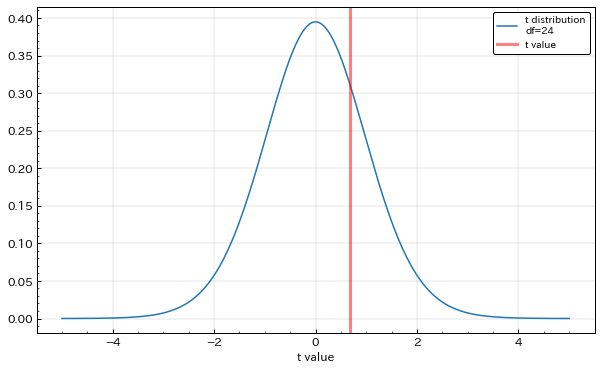

In [14]:
# t分布サンプリング
t_range = np.linspace(-5,5,200)
t_value_ar = []
for i in t_range:
    t_value_ar.append(stats.t.pdf(x=i, df=len(values1)-1))

# plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t_range, t_value_ar, label="t distribution\ndf={}".format(len(values1)-1))
# t value
ax.axvline(x=0.679, ymin=0, ymax=1, color="red", lw=3, linestyle="-", alpha=0.5, label="t value")
ax.set_xlabel("t value")
ax.legend()

### (7) 効果量を計算する。
- 検定の結果が優位であれば、効果量を計算し意義を評価する。<br>

### 判定
結果は優位でないため、評価無し。<br>